# Example with MovieLens 100k data

Download and extract from: https://grouplens.org/datasets/movielens/100k/.


In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
%matplotlib inline

print(tf.__version__)
print(tf.test.is_gpu_available())
tf.keras.backend.clear_session()

C:\envs\TF2FactorizationMachine\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\envs\TF2FactorizationMachine\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\envs\TF2FactorizationMachine\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\envs\TF2FactorizationMachine\lib\site-packages\tensorflow\python\framework\dtypes.

2.0.0-beta1
True


## Load and prep data

Load ua.base and ua.test from the MovieLens dataset to use as train and test, respectively. These are tab separated ascii with no headers.

Set paths below as appropriate depending on data location and notebook working directory. This assumes data is in repo/data/ml-100k/ and running from either repo/examples or repo/.


In [2]:
def load_move_lens_100k(path: str):

    load_args = {'sep':'\t', 
                 'header': None,
                 'names': ['user_id', 'item_id', 'rating', 'timestamp']}

    try:
        data = pd.read_csv(path, **load_args)
    except FileNotFoundError:
        data = pd.read_csv('../' + path, **load_args)

    return data

train = load_move_lens_100k(path='data/ml-100k/ua.base')
test = load_move_lens_100k(path='data/ml-100k/ua.test')

print(train.shape)
print(test.shape)

(90570, 4)
(9430, 4)


To prep the data, pd.get_dummies is used to one-hot encode everything. This produces a dense representation which is obviously horrendously memory inefficient. But it's fine for a first pass. Probably. 

In [3]:
n_train = train.shape[0]

train_test = pd.concat((train, test), 
                 axis=0)

x = pd.concat((pd.get_dummies(train_test.user_id), pd.get_dummies(train_test.item_id)), 
              axis=1).values.copy()

x_train = x[0:n_train, :]
y_train = train[['rating']].values

x_test = x[n_train::, :]
y_test = test[['rating']].values

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(90570, 2625) (90570, 1)
(9430, 2625) (9430, 1)


## Train model

Uses train_step (see 1_model_development.ipynb) which calculates predictions, loss and gradients, and applies these to the model.

There's nothing fancy here - just basic stochastic gradient descent. There's no optimizer with adaptive learning rates or momentum or any of that jazz. So expect local minima, and set a conservative learning rate - somewhere > "will take forever" and < "exploding" would be a good choice (0.3?).   

A randomly selected batch of indexes from x_train each epoch. Modify the size of this by setting batch_size_pc. Epochs refer to one training pass with a single batch, not a pass of the whole dataset.

W0902 22:27:39.176810 27172 deprecation.py:323] From C:\envs\TF2FactorizationMachine\lib\site-packages\tensorflow\python\ops\math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 201 / 10000: Loss: 1.1346462274785925, last change: 0.007429047671231093
Epoch 401 / 10000: Loss: 1.052076077503354, last change: 0.012748423207212145
Epoch 601 / 10000: Loss: 1.0184963662565403, last change: 0.010732164698739721
Epoch 801 / 10000: Loss: 0.9840947226071507, last change: 0.00028884651727678623
Epoch 1001 / 10000: Loss: 0.9540976132570504, last change: 0.02073231661877184
Epoch 1201 / 10000: Loss: 0.9552329703631278, last change: 0.006501716991848316
Epoch 1401 / 10000: Loss: 0.9256827279776708, last change: 0.014955328269672497
Epoch 1601 / 10000: Loss: 0.9232545967612312, last change: 0.0027404070618767262
Epoch 1801 / 10000: Loss: 0.9329860946351154, last change: 0.012765361682306908
Epoch 2001 / 10000: Loss: 0.9217274519794669, last change: 0.004340360069309712
Epoch 2201 / 10000: Loss: 0.904146748561466, last change: 0.0003985969128784683
Epoch 2401 / 10000: Loss: 0.9011128118239544, last change: 0.013886576158517072
Epoch 2601 / 10000: Loss: 0.906558724595820

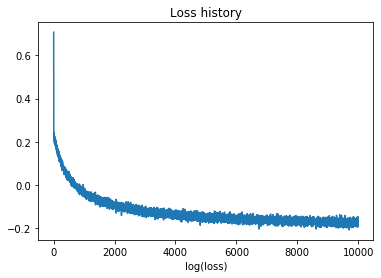

In [4]:
from fmachine.helpers import train_step, l2_loss
from fmachine import FactorizationMachine

mod = FactorizationMachine(m=x.shape[1], 
                           k=100)

epochs = 10000
batch_size_pc = 0.2
bs, ws, vs, losses = [], [], [], []

for e in range(epochs):
    
    # Randomly sample a training batch
    idx = np.random.choice(n_train, int(n_train * batch_size_pc ), 
                           replace=False)
    
    cur_loss = train_step(mod=mod, 
                     x=tf.cast(x_train[idx], tf.double),
                     y_true=tf.cast(y_train[idx], tf.double),
                     lr=0.25,
                     loss_f=l2_loss)
    
    # Logging
    losses.append(cur_loss)
    bs.append(mod.b.numpy()[0])
    ws.append(mod.w.numpy()[0])
    vs.append(mod.v.numpy()[0])
    
    # Print every few steps
    if (e > 1) & (e % 200 == 0):
        print(f"Epoch {e + 1} / {epochs}: Loss: {cur_loss.numpy()}, last change: {np.abs(losses[-1] - losses[-2])}")
        
    # And maybe early stop if it seems like a good idea
    if e > 10:
        if np.mean(losses[-10:-1]) < 0.1:
            print(f"Early stopping, loss={cur_loss.numpy()}")
            break


plt.plot(np.log(losses[2::]))
plt.title('Loss history')
plt.xlabel('Epoch')
plt.xlabel('log(loss)')
plt.show()

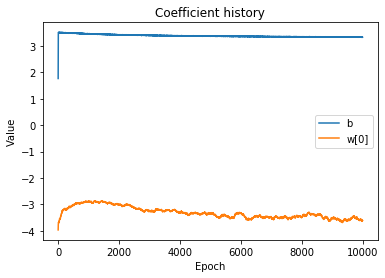

In [5]:
plt.plot(bs, 
         label='b')
plt.plot(np.log(ws),
         label='w[0]')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Coefficient history')
plt.legend()
plt.show()

(100, 2625)


Text(0.5, 1.0, '(some of) V')

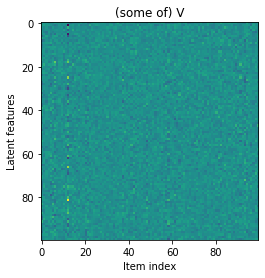

In [6]:
print(mod.v.shape)
plt.imshow(mod.v.numpy()[:, 0:100])
plt.ylabel('Latent features')
plt.xlabel('Item index')
plt.title('(some of) V')

## Predicting

Predict for test and train sets and check performance. 

This is done in a batches here to avoid memory possible errors caused by casting everything up to double precision.... 

In [19]:
n_chunks = 50
y_pred_train = np.empty(shape=y_train.shape)
y_pred_test = np.empty(shape=y_test.shape)

for x_train_idx, x_test_idx in zip(np.array_split(np.arange(y_train.shape[0]), n_chunks),
                               np.array_split(np.arange(y_test.shape[0]), n_chunks)):
    
    y_pred_train[x_train_idx] = mod(tf.cast(x_train[x_train_idx], tf.double))
    y_pred_test[x_test_idx] = mod(tf.cast(x_test[x_test_idx], tf.double))

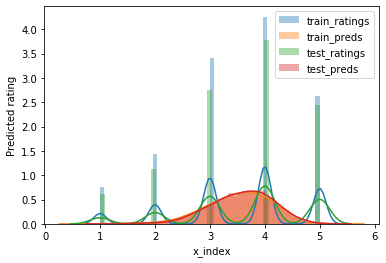

In [20]:
import seaborn as sns

sns.distplot(train.rating,
             label='train_ratings')
sns.distplot(y_pred_train,
             label='train_preds')
sns.distplot(test.rating,
             label='test_ratings')
sns.distplot(y_pred_test,
             label='test_preds')
plt.xlabel('x_index')
plt.ylabel('Predicted rating')
plt.legend()

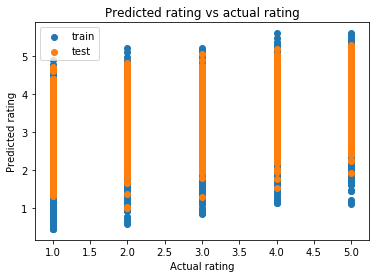

In [9]:
plt.scatter(y_train, y_pred_train, 
            label='train')
plt.scatter(y_test, y_pred_test, 
            label='test')
plt.xlabel('Actual rating')
plt.ylabel('Predicted rating')
plt.title('Predicted rating vs actual rating')
plt.legend()

In [10]:
print(f"MSE train: {np.mean((y_pred_train - y_train) ** 2)}")
print(f"MSE test: {np.mean((y_pred_test - y_test) ** 2)}")

MSE train: 0.840382413707893
MSE test: 0.925986351148047


In [11]:
import pickle
pickle.dump(mod, open('FM.mod', 'wb'))

# Compare to CF model

In [14]:
from fmachine.other_models import keras_cf

cf = keras_cf(train.user_id, train.item_id,
              user_k=40,
              item_k=40,
              lr=0.25,
              reg=6)

cf_history = cf.fit({'user_input': train.user_id, 'item_input': train.item_id},
                    train.rating - train.rating.mean(),
                    epochs=200,
                    batch_size=30000,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=0)

train_preds = cf.predict({'user_input': train.user_id, 'item_input': train.item_id})
test_preds = cf.predict({'user_input': test.user_id, 'item_input': test.item_id})

print(f"MSE Train: {np.mean(((train_preds.squeeze() + train.rating.mean()) - train.rating) ** 2)}")
print(f"MSE Test: {np.mean(((test_preds.squeeze() + train.rating.mean()) - test.rating) ** 2)}")

C:\envs\TF2FactorizationMachine\lib\site-packages\tensorflow\python\framework\indexed_slices.py:414: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


MSE Train: 0.8953658955638217
MSE Test: 0.9668112569536361


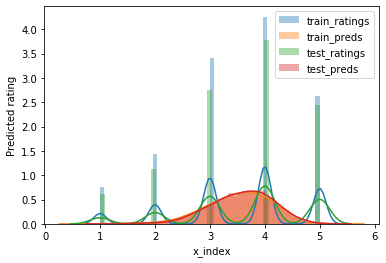

In [18]:
sns.distplot(train.rating,
             label='train_ratings')
sns.distplot(y_pred_train,
             label='train_preds')
sns.distplot(test.rating,
             label='test_ratings')
sns.distplot(y_pred_test,
             label='test_preds')
plt.xlabel('x_index')
plt.ylabel('Predicted rating')
plt.legend()